In [173]:
library(tidyverse)
library(repr)

In [174]:
options(repr.plot.width=10, repr.plot.height=5)

In [175]:
ads_df = as_tibble(read.csv('data/ads.csv', stringsAsFactors = FALSE))
dbr_df = as_tibble(read.csv('data/delivery_by_region.csv', stringsAsFactors = FALSE))

In [176]:
ads_df$spend_estimate = (ads_df$spend_lower_bound + ads_df$spend_upper_bound)/2
ads_df$impressions_estimate = (ads_df$impressions_lower_bound + ads_df$impressions_upper_bound)/2

In [177]:
ads_df$page_name_short = substr(ads_df$page_name, 1, 18)

ads_df$page_name_bin = ads_df$page_name_short

ads_df[
    (ads_df$page_name != "Liberal Party of Canada | Parti libéral du Canada")&
    (ads_df$page_name != "Conservative Party of Canada - Parti conservateur du Canada"), 
    "page_name_bin"
    ] = "Other"

In [178]:
dbr_df = merge(dbr_df, ads_df, by.x = 'ad_id', by.y = 'id')
dbr_df = as_tibble(dbr_df)

# We only have the cost by ad, not by region. We can apportion the spent value across regions by the percentage
dbr_df$spend_by_region_estimate = dbr_df$percentage*dbr_df$spend_estimate
dbr_df$impressions_by_region_estimate = dbr_df$percentage*dbr_df$impressions_estimate

In [185]:
dbr_df$region_bin = dbr_df$region

top_regions_df = dbr_df %>%
    group_by(region) %>%
    summarise(spend_estimate = sum(spend_by_region_estimate, na.rm = TRUE)) %>%
    top_n(9, spend_estimate)

dbr_df[
    !(dbr_df$region %in% top_regions_df$region),
    "region_bin"
    ] = "Other"

# Page analysis

In [180]:
spend_by_page_df = ads_df %>% 
group_by(page_name_short) %>% 
summarise(
    spend_estimate = sum(spend_estimate, na.rm = TRUE), 
    impressions_estimate = sum(impressions_estimate, na.rm = TRUE), 
    impressions_per_cad = sum(impressions_estimate, na.rm = TRUE)/sum(spend_estimate, na.rm = TRUE),
    ad_count = n()
    )

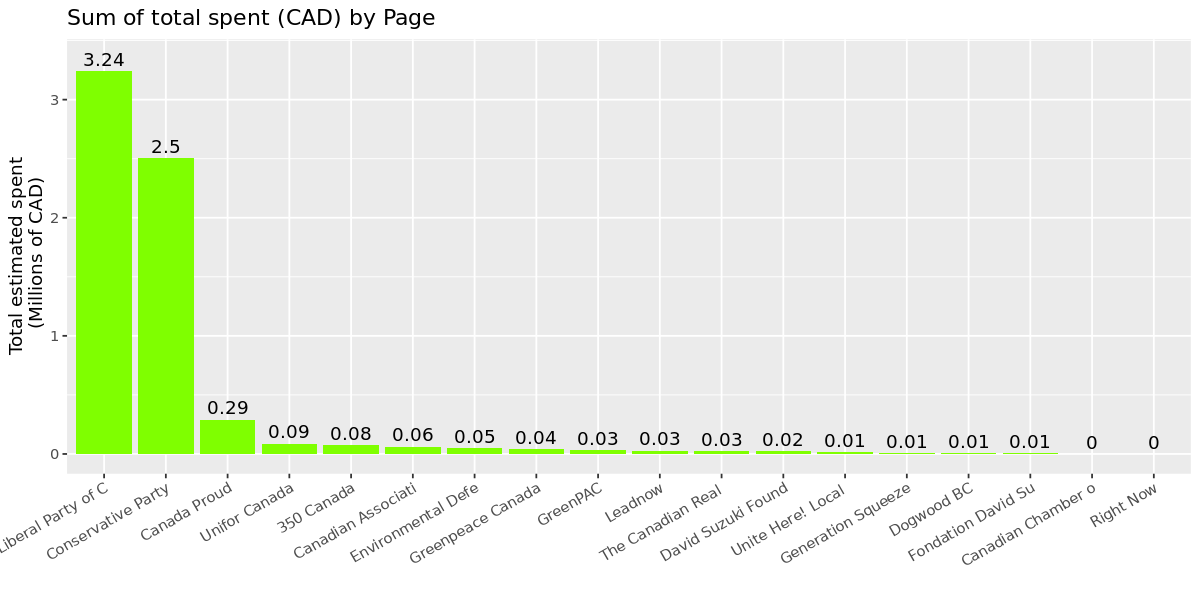

In [181]:
# options(repr.plot.width=5, repr.plot.height=3)
ggplot(data = spend_by_page_df, aes(x = reorder(page_name_short, -spend_estimate), y = spend_estimate/1000000,
    label = round(spend_estimate/1000000, digits = 2))) + 
    geom_col( fill = "chartreuse") +
    geom_text(nudge_y = 0.1) +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1)) +
    labs(y = "Total estimated spent\n (Millions of CAD)", x = "", title = "Sum of total spent (CAD) by Page")
## How much was spent by region

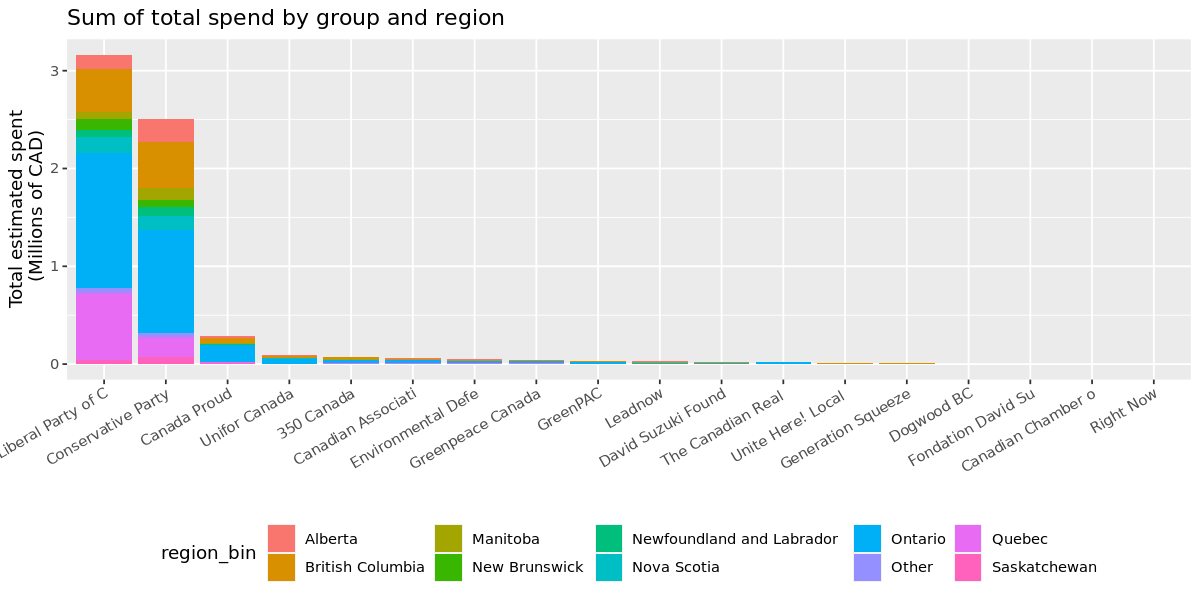

In [187]:
ggplot(data = dbr_df, aes(
        x = reorder(page_name_short, spend_by_region_estimate, function(x){-sum(x)}),
        weight = spend_by_region_estimate/1000000,
        label = spend_by_region_estimate/1000000,
        fill = region_bin)) +
    geom_bar() +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1), legend.position = "bottom") +
    labs(y = "Total estimated spent\n (Millions of CAD)", x = "", title = "Sum of total spend by group and region")

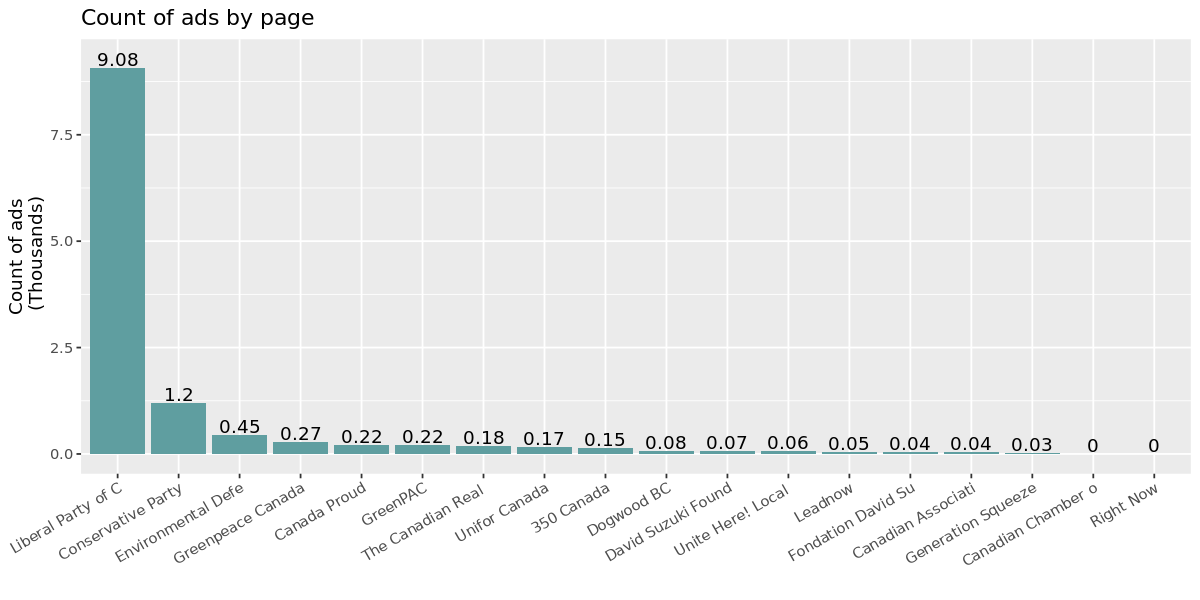

In [188]:
# options(repr.plot.width=5, repr.plot.height=3)
ggplot(data = spend_by_page_df, aes(x = reorder(page_name_short, -ad_count), y = round(ad_count/1000, digits = 2), label = round(ad_count/1000, digits = 2))) + 
    geom_col(fill = "cadetblue") +
    geom_text(nudge_y = 0.2) +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1)) +
    labs(y = "Count of ads\n (Thousands)", x = "", title = "Count of ads by page")
## How much was spent by region 

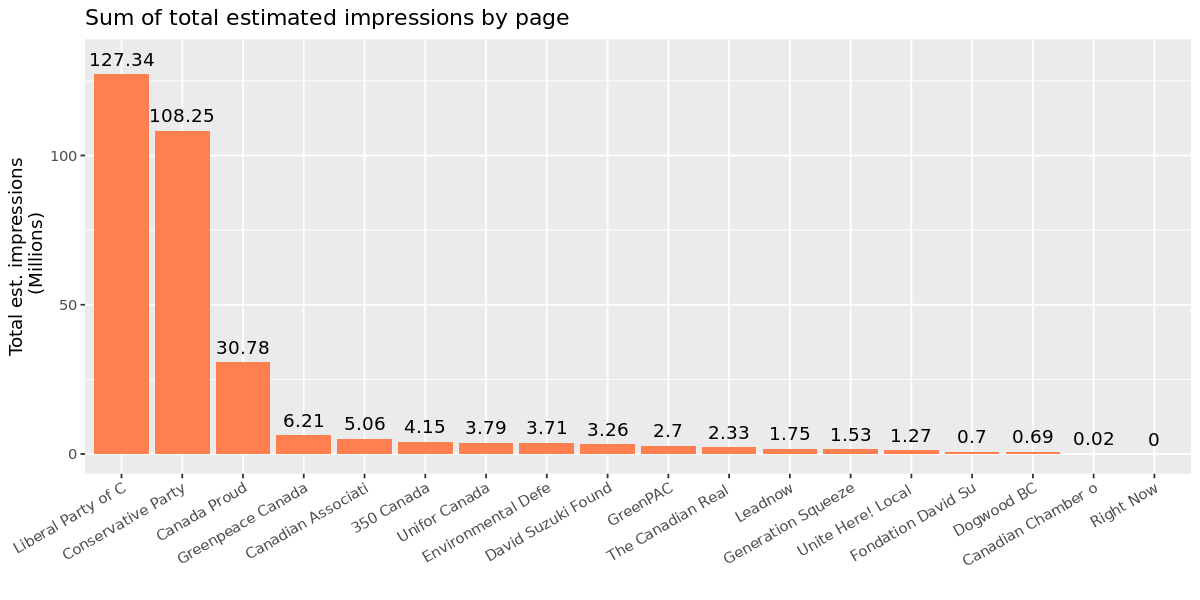

In [189]:
ggplot(data = spend_by_page_df, 
        aes(
            x = reorder(page_name_short, -impressions_estimate), 
            y = round(impressions_estimate/1000000, digits = 2), 
            label = round(impressions_estimate/1000000, digits = 2)
        )
    ) + 
    geom_col(fill = "coral") +
    geom_text(nudge_y = 5) + 
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1)) +
    labs( y = "Total est. impressions\n (Millions)", x = "", title = "Sum of total estimated impressions by page")

### Number of ads per group

A very interesting thing is that, altough there are way less ads on the Conservative Party than in the Liberal Party, the total spent is very comparable. This may indicate that the ads on the Conservative Party's page tend to be fewer, more expesive ads.

# Region Analysis

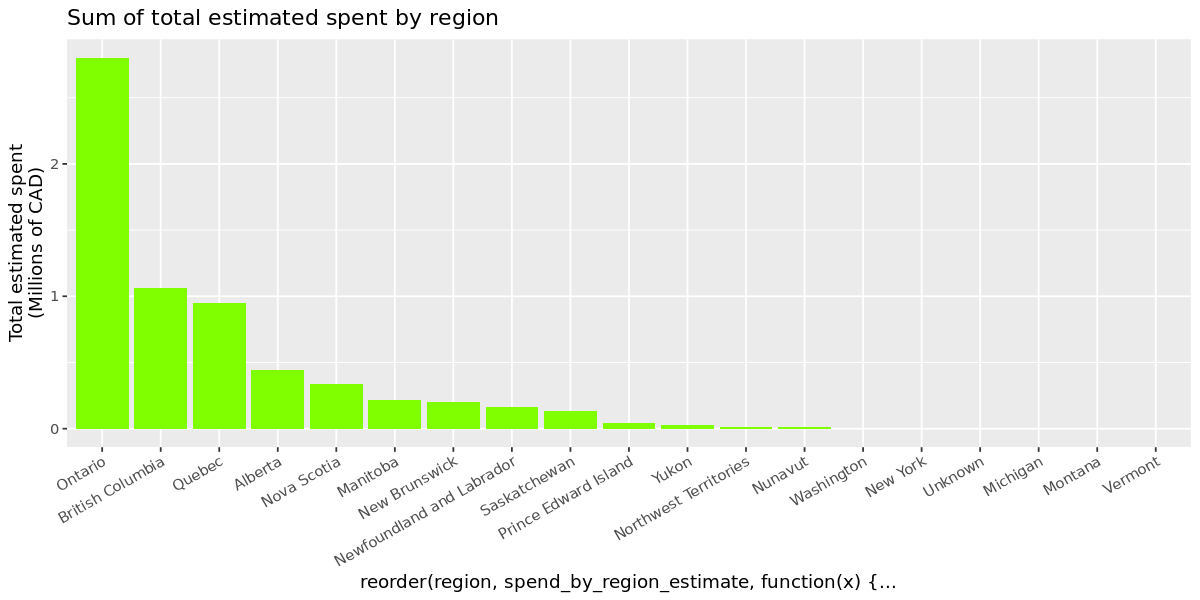

In [190]:
ggplot(data = dbr_df, 
        aes(
            x = reorder(region, spend_by_region_estimate, function(x){-sum(x)}), 
            weight = spend_by_region_estimate/1000000
        )
    ) +
    geom_bar(fill = "chartreuse") +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1), legend.position = "bottom") +
    labs(y = "Total estimated spent\n(Millions of CAD)", title = "Sum of total estimated spent by region")

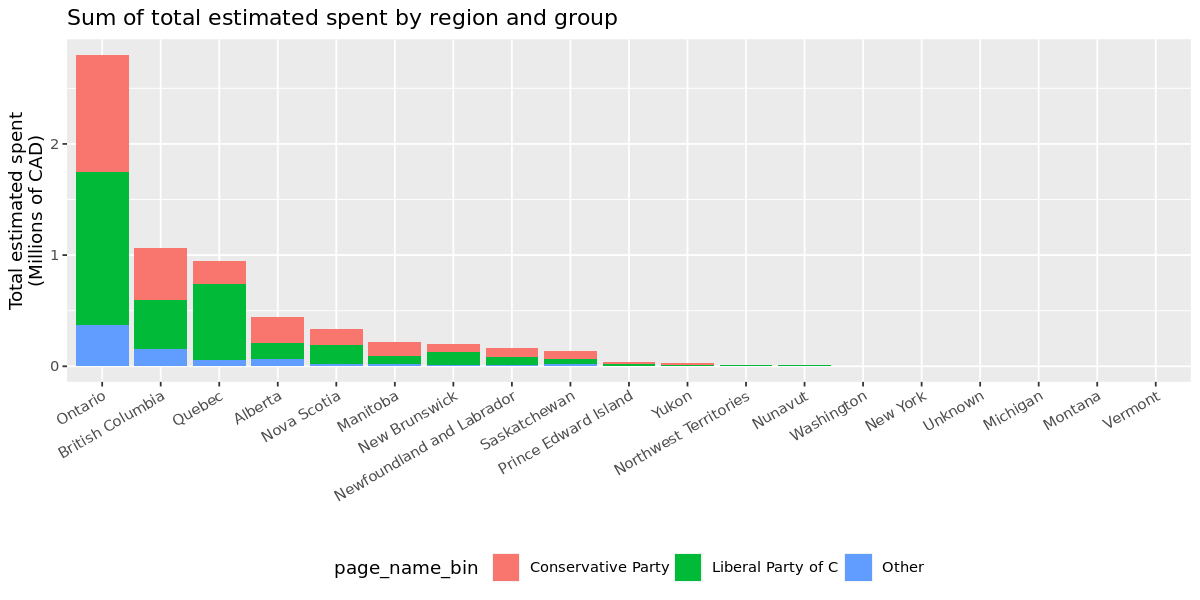

In [191]:
# options(repr.plot.width=8, repr.plot.height=4)
ggplot(data = dbr_df, 
        aes(
            x = reorder(region, spend_by_region_estimate, function(x){-sum(x)}), 
            weight = spend_by_region_estimate/1000000, 
            fill = page_name_bin
        )
    ) +
    geom_bar() +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1), legend.position = "bottom") +
    labs(y = "Total estimated spent\n(Millions of CAD)", x = "", title = "Sum of total estimated spent by region and group")

## Relationship between spent value and audience reached (impressions)

### Cost of Ads

Warning message:
“Ignoring unknown parameters: oulier.shape”Warning message:
“Removed 794 rows containing non-finite values (stat_boxplot).”

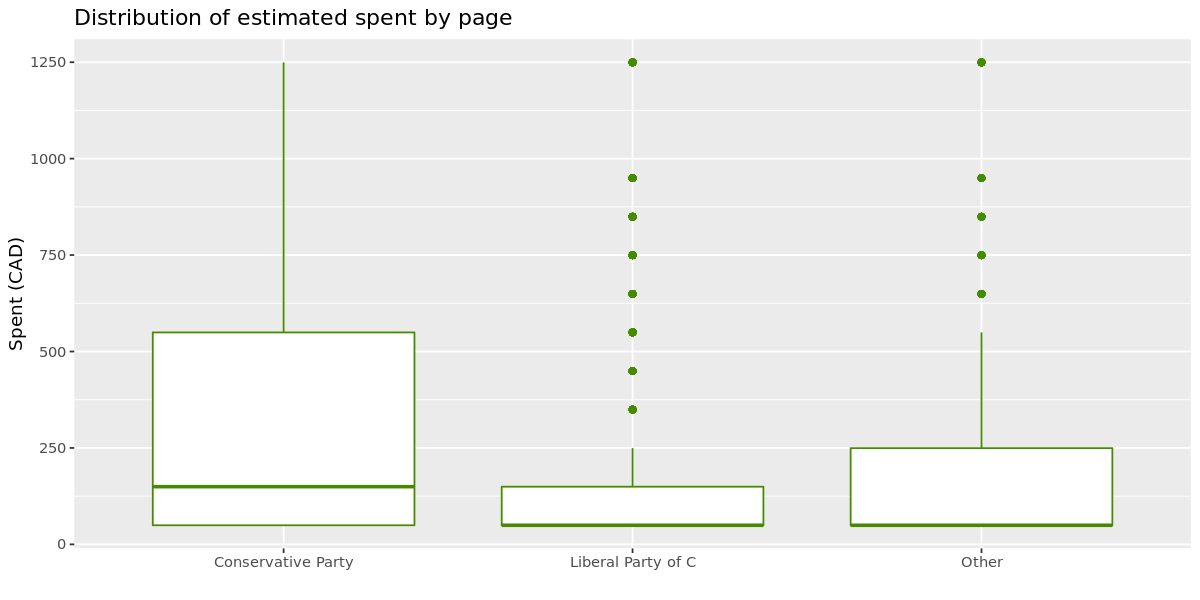

In [192]:
ggplot(data = ads_df) +
    geom_boxplot(mapping = aes(x = page_name_bin, y = spend_estimate), oulier.shape = NA, color = "chartreuse4") +
    scale_y_continuous(limits = quantile(ads_df$spend_estimate, c(0.1, 0.9))) +
    labs(y = "Spent (CAD)", x = "", title = "Distribution of estimated spent by page")

The above graph confirms the hypotesis that the Conservative Party's page runs more expesive ads than the Liberal Party' page. The average amount spent per and in CP's page is as high as the the third quartile of the ads on the LP's page. 

Warning message:
“Removed 53 rows containing missing values (geom_point).”

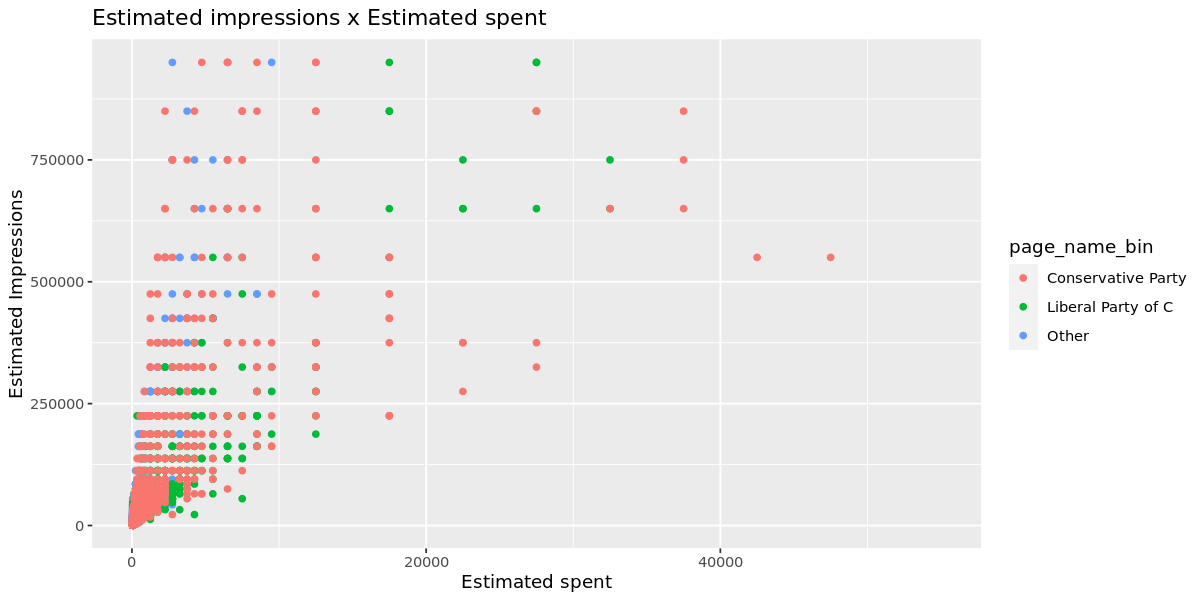

In [193]:
# There is a clear positive and linear relationship between amount spent and number of impressions
ggplot(data = ads_df) +
    geom_point(mapping = aes(x = spend_estimate, y = impressions_estimate, color = page_name_bin)) +
    labs( y = "Estimated Impressions", x = "Estimated spent", title = "Estimated impressions x Estimated spent")

There seems to be clear positive relationship between amout spent and total impressions, in other words, the more you spend on an ad, the more impressions you get. This relationship alse seems to be linear. This means that the ratio of impressions obtained per dollar spent is more or less equal both to cheap and expensive ads. <br><br>
This suggests that both strategies (many cheap ads vs fewer expensive ads) should be about equally cost effective.

In [194]:
 ads_df %>% group_by(page_name_bin) %>% summarise(impressions_per_cad = sum(impressions_estimate, na.rm = TRUE)/sum(spend_estimate, na.rm = TRUE))

page_name_bin,impressions_per_cad
Conservative Party,43.22956
Liberal Party of C,39.25326
Other,90.65513


In [195]:
page_regions_df = dbr_df %>% 
group_by(page_name_bin, region_bin) %>% 
summarise(
    spend_estimate = sum(spend_by_region_estimate, na.rm = TRUE), 
    impressions_estimate = sum(impressions_by_region_estimate, na.rm = TRUE), 
    impressions_per_cad = sum(impressions_by_region_estimate, na.rm = TRUE)/sum(spend_by_region_estimate, na.rm = TRUE),
    )

`summarise()` has grouped output by 'page_name_bin'. You can override using the `.groups` argument.

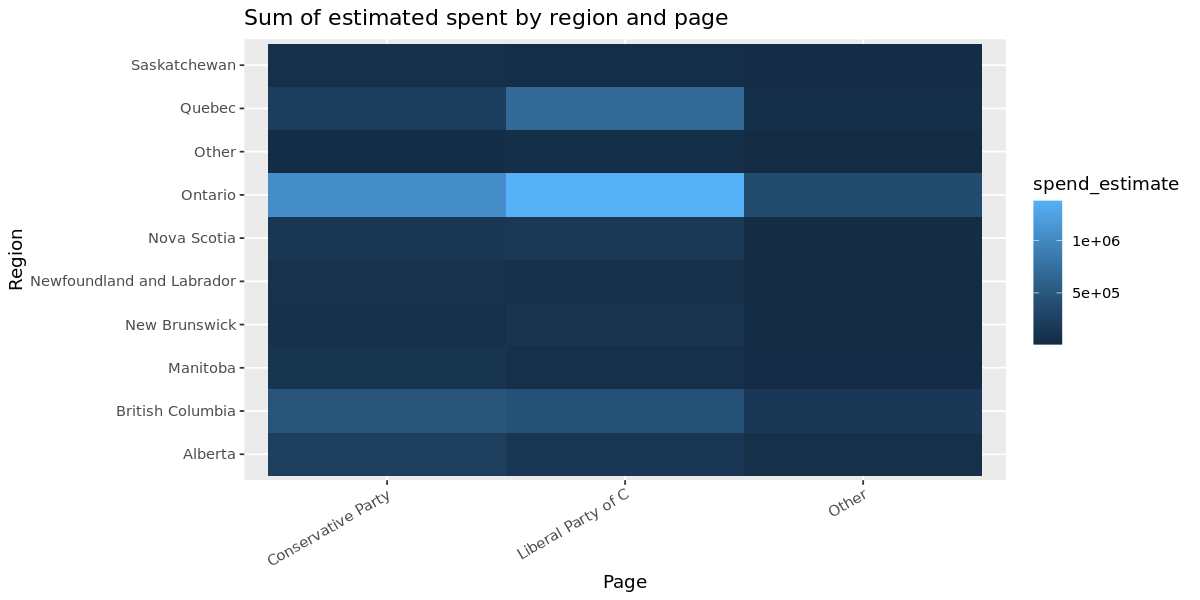

In [196]:
ggplot(data = page_regions_df) +
    geom_tile(mapping = aes(x = page_name_bin, y = region_bin, fill = spend_estimate)) +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1)) + 
    labs(y = "Region", x = "Page", title = "Sum of estimated spent by region and page")

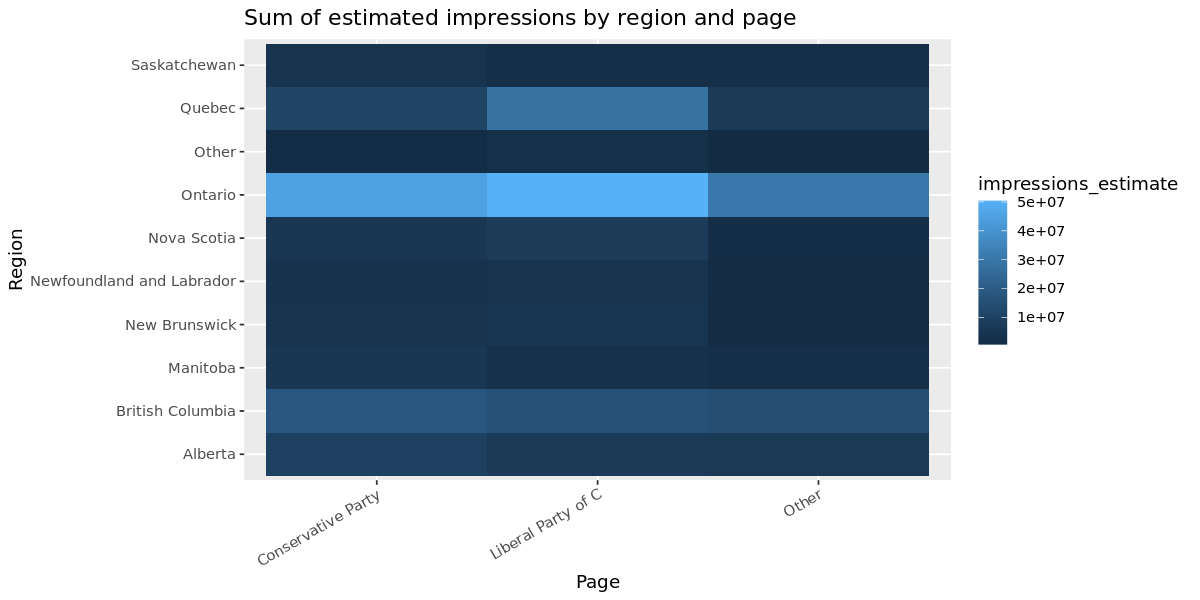

In [197]:
ggplot(data = page_regions_df) +
    geom_tile(mapping = aes(x = page_name_bin, y = region_bin, fill = impressions_estimate)) +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1)) +
    labs(y = "Region", x = "Page", title = "Sum of estimated impressions by region and page")

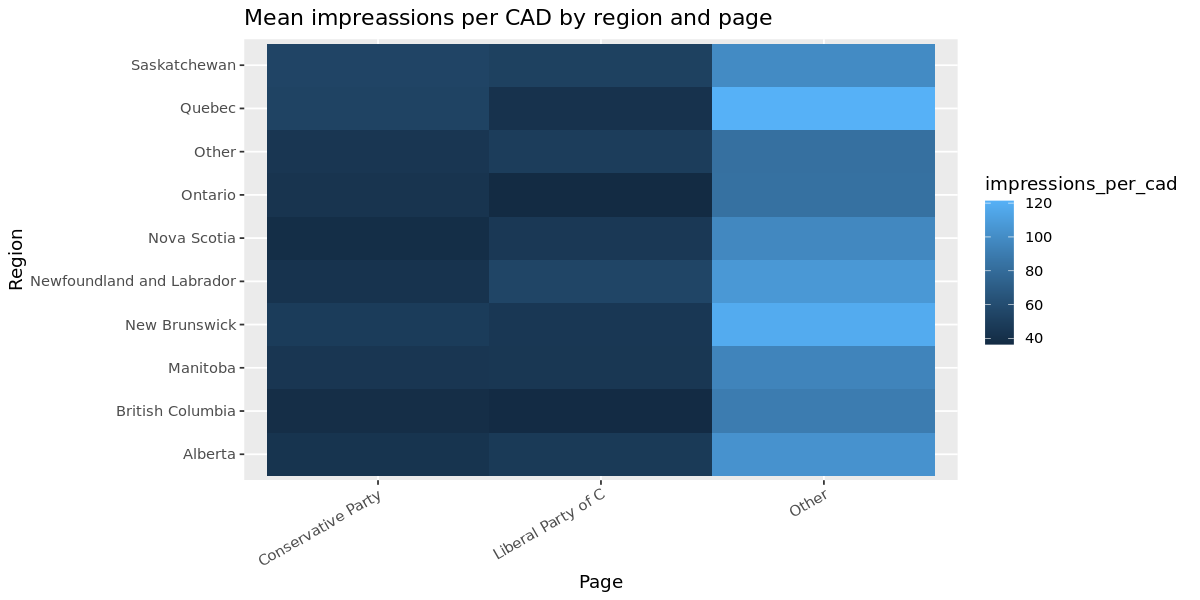

In [199]:
ggplot(data = page_regions_df) +
    geom_tile(mapping = aes(x = page_name_bin, y = region_bin, fill = impressions_per_cad)) +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1)) +
    labs(y = "Region", x = "Page", title = "Mean impreassions per CAD by region and page")

For the two major pages, one dollar buys about 40 impressions. The CP's page, with the fewer more expensive ads strategy gets 4 additional impressions per dollar. An increase of 10%

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 53 rows containing non-finite values (stat_bin).”

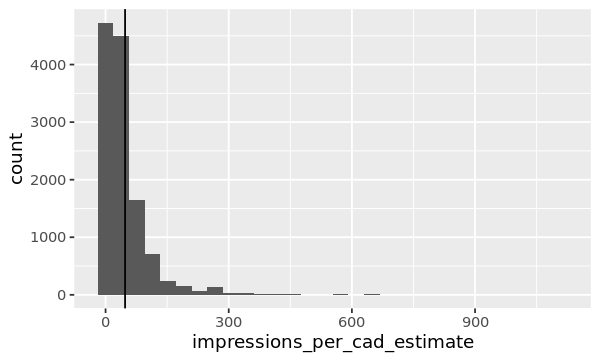

In [201]:
ads_df$impressions_per_cad_estimate = ads_df$impressions_estimate/ads_df$spend_estimate
mean_ipc = mean(ads_df$impressions_per_cad_estimate, na.rm = TRUE)
ggplot(data = ads_df) +
    geom_histogram(mapping = aes(x = impressions_per_cad_estimate)) +
    geom_vline(xintercept = mean_ipc)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 53 rows containing non-finite values (stat_bin).”

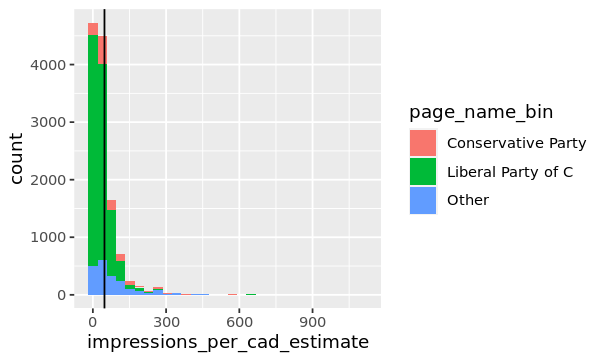

In [202]:
ggplot(data = ads_df) +
    geom_histogram(mapping = aes(x = impressions_per_cad_estimate, fill = page_name_bin)) +
    geom_vline(xintercept = mean_ipc)